# Matching Algorithm - Matching with Food Description/Name column

There is something wrong with the matching algo. When I run it one i get weird results but when I run it the second time I get better results in some categories 

##### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re #regular expressions 
from fuzzywuzzy import process, fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

##### Read In Data

                                                      M&W Reduced

In [2]:
#pd.set_option('display.max_rows', None)
redFood = pd.read_csv(r"C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\Reduced Super Group\Cleaned\Reduced_SecondClean.csv", index_col=0)
redFood.rename(columns={'Super Group':'SuperGroup'})
redFood['Food Name'] = redFood['Food Name'].str.lower()
redFood.head()

,Food Code,Food Name,Group,Super Group,Sale format(s)
0,17-208,"beer, bitter, best, premium",QA,Alcoholic beverages,"can, can multipack, bottle, bottle multipack"
1,17-224,"cider, sweet",QC,Alcoholic beverages,"can, can multipack, bottle, bottle multipack"
2,17-234,port,QF,Alcoholic beverages,bottle
3,17-236,"sherry, medium",QF,Alcoholic beverages,bottle
4,17-247,"spirits, 40% volume",QK,Alcoholic beverages,"bottle, miniature"


Creating a Source column to indicate where I got weight data from

In [3]:
redFood['Source'] = ' '

                                                         FPS Data

In [4]:
CleanRetai = pd.read_csv(r'C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\FoodPortionSized\FPS_VJ.csv')
CleanRetai['Food Name'] = CleanRetai['Food Name'].str.lower()
CleanRetai.tail()

,Group,Brand,Food Name,Portion Consumed,Weight,PurEqualCon,Purchased,Format,Source
2672,YOGHURTS AND FROMAGE FRAIS,NaN,onken,NaN,200g,NaN,NaN,NaN,NaN
2673,YOGHURTS AND FROMAGE FRAIS,NaN,petit danoneâ,small,50g,NaN,NaN,NaN,NaN
2674,YOGHURTS AND FROMAGE FRAIS,NaN,st ivel fiendish faces,NaN,50g,NaN,NaN,NaN,NaN
2675,YOGHURTS AND FROMAGE FRAIS,NaN,baby fromage frais,Baby Danone,60g,Y,NaN,NaN,NaN
2676,YOGHURTS AND FROMAGE FRAIS,Heinz,baby fromage frais,Jar,163g,Y,NaN,NaN,NaN


                            Identify Food Portion Sizes that are equivalent to Retail sold portions

In [5]:
CleanRetail = CleanRetai[CleanRetai['PurEqualCon'].isin(['Y', 'Y, P'])]
CleanRetail#[CleanRetail['Food Name'].str.contains('bread')]#.head()

,Group,Brand,Food Name,Portion Consumed,Weight,PurEqualCon,Purchased,Format,Source
0,BABY FOODS,Boots,"first harvest,dessert starter",NaN,125g,Y,NaN,NaN,NaN
1,BABY FOODS,Boots,"first harvest, infant desserts",NaN,125g,Y,NaN,NaN,NaN
2,BABY FOODS,Boots,"first harvest,infant savouries",NaN,125g,Y,NaN,NaN,NaN
3,BABY FOODS,Boots,"first harvest,junior desserts",NaN,190g,Y,NaN,NaN,NaN
4,BABY FOODS,Boots,"first harvest,junior savouries",NaN,190g,Y,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2666,YOGHURTS AND FROMAGE FRAIS,NaN,"tesco, yoplait, fruit on the bottom",pots,100g,Y,NaN,NaN,NaN
2667,YOGHURTS AND FROMAGE FRAIS,NaN,"tesco, yoplait light fruit",pots,100g,Y,NaN,NaN,NaN
2668,YOGHURTS AND FROMAGE FRAIS,NaN,"country love, fruit",NaN,150g,Y,NaN,NaN,NaN
2675,YOGHURTS AND FROMAGE FRAIS,NaN,baby fromage frais,Baby Danone,60g,Y,NaN,NaN,NaN


###                                                        Match Data (Hybrid Algo).

###### Once matched, Import Weight and Unit Columns into Reduced M&W table

Seem to work better when run twice. Something isn't working well with the matching process

###### Algorithm

In [9]:
%%time

def preprocess_text(df, column_name):
    return df[column_name].str.lower()

def fuzzy_matching_score(source, target):
    return fuzz.partial_token_set_ratio(source, target)

def get_most_similar_indices(tfidf_red_food, tfidf_clean_retail):
    similarities = cosine_similarity(tfidf_red_food, tfidf_clean_retail)
    return similarities.argmax(axis=1)

def hybrid_fuzzy_matching(CleanRetail, redFood):
    # Set thresholds for matching
    partial_token_set_ratio_threshold = 98
    cosine_similarity_threshold = 0.70
    min_similarity_threshold = 0.47

    # Preprocess text data in both DataFrames for the "Food Name" field.
    CleanRetail['Food Name'] = preprocess_text(CleanRetail, 'Food Name')
    redFood['Food Name'] = preprocess_text(redFood, 'Food Name')

    # Step 1: Partial Token Set Ratio (Fuzzy Matching)
    CleanRetail['Partial Token Set Ratio'] = CleanRetail['Food Name'].apply(lambda x: fuzzy_matching_score(x, redFood['Food Name']))
    potential_matches = CleanRetail[CleanRetail['Partial Token Set Ratio'] >= partial_token_set_ratio_threshold]

    # Step 2: TF-IDF and Cosine Similarity (Text Matching) - Use combined matches as input
    vectorizer = TfidfVectorizer()
    vectorizer.fit(potential_matches['Food Name'])
    tfidf_clean_retail = vectorizer.transform(potential_matches['Food Name'])
    tfidf_red_food = vectorizer.transform(redFood['Food Name'])

    # Find the most similar match for each redFood product
    max_sim_indices = get_most_similar_indices(tfidf_red_food, tfidf_clean_retail)
    max_sim_scores = cosine_similarity(tfidf_red_food, tfidf_clean_retail).max(axis=1)

    # Update redFood DataFrame with matched information and sources
    redFood['Similarity Score'] = max_sim_scores
    redFood['Weight'] = potential_matches['Weight'].values[max_sim_indices]
    redFood['PurEqualCon'] = potential_matches['PurEqualCon'].values[max_sim_indices]
    redFood['Portion Consumed'] = potential_matches['Portion Consumed'].values[max_sim_indices]

    # Create a mapping dictionary for matched indices to their sources
    match_indices_to_sources = dict(zip(potential_matches.index, potential_matches['Source']))

    # Map the sources and format to the redFood DataFrame based on matched indices
    redFood['Source'] = redFood.index.map(lambda i: match_indices_to_sources.get(max_sim_indices[i], ''))
    
    # Set to NaN for rows where similarity score is below the minimum threshold
    redFood.loc[redFood['Similarity Score'] < min_similarity_threshold, ['Weight', 'PurEqualCon', 'Portion Consumed', 'Source']] = ''

    return redFood

# Call the hybrid_fuzzy_matching function and get the matched DataFrame
redFood_matched = hybrid_fuzzy_matching(CleanRetail.copy(), redFood.copy())

CPU times: total: 5.92 s
Wall time: 6 s


In [14]:
#pd.set_option('display.max_rows', None)
#redFood_matched.head()

Identifying Matched Items with weights

In [12]:
d = redFood_matched.loc[redFood_matched['Weight'] != '']
d#['Food Name'].value_counts().sum()

,Food Code,Food Name,Group,Super Group,Sale format(s),Source,Similarity Score,Weight,PurEqualCon,Portion Consumed
0,17-208,"beer, bitter, best, premium",QA,Alcoholic beverages,"can, can multipack, bottle, bottle multipack",NaN,0.707107,574g,Y,1 pint
1,17-224,"cider, sweet",QC,Alcoholic beverages,"can, can multipack, bottle, bottle multipack",,0.609864,25g,Y,NaN
4,17-247,"spirits, 40% volume",QK,Alcoholic beverages,"bottle, miniature",,1.000000,29g,Y,1 miniature
5,17-239,"vermouth, dry",QG,Alcoholic beverages,bottle,NaN,0.640264,50g/100g,Y,per bag
6,17-752,"wine, red",QE,Alcoholic beverages,"bottle, small bottle, box",,1.000000,200g,Y,I small bottle
7,17-756,"wine, white, medium",QE,Alcoholic beverages,"bottle, small bottle, box",,0.720499,200g,Y,I small bottle
9,17-632,"coffee, cappuccino, latte",P,Beverages,NaN,,1.000000,170g,Y,1 average vending machine cup
11,17-744,cranberry fruit juice drink,PE,Beverages,"carton, tetrapak, bottle",,0.756561,200g,Y,individual carton
13,17-672,"energy drink, carbonated",PCA,Beverages,"can, ready to drink bottle, sharing bottle",,0.876232,250ml,Y,slim can
14,17-745,"grape juice, unsweetened",PE,Beverages,"carton, tetrapak, bottle",,0.580244,12g,"Y, P",1 sachet


Manual Crossreferencing

In [440]:
pd.set_option('display.max_columns', None)
CleanRetail[CleanRetail['Food Name'].str.contains('green')]

,Group,Brand,Food Name,Portion Consumed,Weight,PurEqualCon,Purchased,Format,Source


#### Export Matched DataSet

In [9]:
#redFood_matched.to_csv(r'C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\ReducedwithWeights\dataproduct.csv')

### 320 / 535 items Matched Using Algo 4 which is a combination of Algo 2 & It uses the fuzz.partial_token_set_ratio & Term Frequency-Inverse Document Frequency

In [11]:
f'Fourth Algorithm Matched {round((320/535) * 100, 2)}% of products between McCane and Widdowson df and Food Portion Sizes df at a threshold of 90 and a Cosine threshold of 70. Contains some errors'

'Fourth Algorithm Matched 59.81% of products between McCane and Widdowson df and Food Portion Sizes df at a threshold of 90 and a Cosine threshold of 70. Contains some errors'

## Plotting Matching Efficiency of Algo 4

Find total counts of food by Super Group

In [12]:
d = redFood_matched[redFood_matched['Weight'] != '']
ax4_s = d.groupby('Super Group')['Food Name'].count().rename('Matched Prod Count', inplace=True).copy().sort_values(ascending=True)
ax4 = pd.DataFrame(ax4_s).reset_index()
ax4

,Super Group,Matched Prod Count
0,Eggs,1
1,Fats and oils,4
2,Alcoholic beverages,6
3,Herbs and spices,6
4,Beverages,8
5,Nuts and seeds,9
6,"Sugars, preserves and snacks",18
7,Meat and meat products,20
8,Milk and milk products,22
9,Fish and fish products,24


In [13]:
ax4_count = redFood_matched.groupby('Super Group')['Food Name'].count().rename('Total Prod Count', inplace=True).copy().sort_values(ascending=True)
ax4_nt = pd.DataFrame(ax4_count).reset_index()
ax4_nt

,Super Group,Total Prod Count
0,Eggs,2
1,Fats and oils,7
2,Alcoholic beverages,8
3,Beverages,14
4,Nuts and seeds,17
5,"Sugars, preserves and snacks",25
6,Fish and fish products,33
7,Milk and milk products,33
8,Herbs and spices,35
9,"Soups, sauces and miscellaneous foods",44


In [14]:
# Evaluating Percentaged Mapped
ax4_counts = ax4_nt.merge(ax4, on='Super Group', how='left')
ax4_counts['%Matched'] = ax4_counts['Matched Prod Count'] / ax4_counts['Total Prod Count'] * 100 

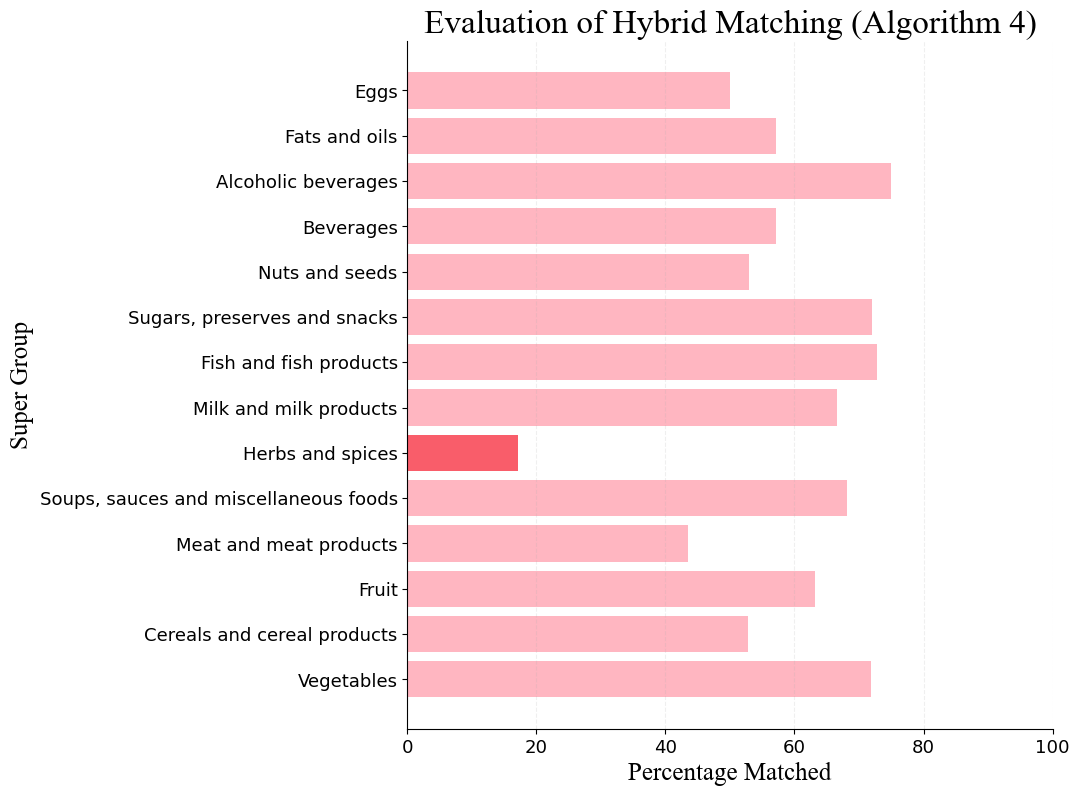

In [15]:
import matplotlib.font_manager as fm

# Find the minimum count in the ax4_counts DataFrame.
min_count4 = ax4_counts['%Matched'].min()

# Create a custom color palette.
bar_colors4 = ['lightpink' if count != min_count4 else '#f95d6a' for count in ax4_counts['%Matched']]

# Set the font family and size for the title.
title_font = fm.FontProperties(family='Times New Roman', size=24)

# Set the font family and size for the axes labels.
axis_font = fm.FontProperties(family='Times New Roman', size=18)

# Create the figure and axes objects.
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the horizontal bar chart.
bars = ax.barh(ax4_counts['Super Group'], ax4_counts['%Matched'], color=bar_colors4)

# Add gridlines to the plot.
ax.grid(axis='x', linestyle='--', alpha=0.2)

# Customize the title, x-axis, and y-axis labels.
ax.set_title('Evaluation of Hybrid Matching (Algorithm 4)', fontproperties=title_font)
ax.set_xlabel('Percentage Matched', fontproperties=axis_font)
ax.set_ylabel('Super Group', fontproperties=axis_font)

# Set the maximum value of the x-axis to 100.
ax.set_xlim(0, 100)

# Adjust the spacing around the plot.
plt.tight_layout(pad=1.0)

# Remove the top and right spines from the plot.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Increase the tick label font size.
ax.tick_params(axis='both', which='major', labelsize=13)

# Invert the y-axis to display the highest match on top.
ax.invert_yaxis()

    # Show the plot.
plt.show()


                                                  NEXT NOTEBOOK